Synthesize Criteo data using sequential CART models. (Note that this file uses the updated synthesis and optimization functions from the `helper_functions.py` file.).

In [1]:
import matplotlib.pyplot as plt
import sys

# Add the parent directory to path
sys.path.append('..')

# Then import
from helper_functions import *

rng = np.random.RandomState(42)

Import Criteo data (small version for testing)

In [2]:
# train_data = pd.read_csv("../../Data/Criteo/cleaned_criteo_small.gz",
#                          compression='gzip', 
#                          sep='\,',
#                          header=0,
#                          engine='python')
# data_set = "small"

train_data = pd.read_csv("../../Data/Criteo/cleaned_criteo.gz",
                         compression='gzip', 
                         sep='\,',
                         header=0,
                         engine='python')
data_set = "full"

View confidential data to synthesize.

In [3]:
train_data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,1,0,0,0
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,0,1,0
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


Set up dictionary of parameter bounds for the Bayesian optimization process. The current state of the code requires a set of bounds for each parameter being optimized.

In [4]:
# define some default bounds for leaf values. These will be appropriately filled in during the loop below

param_bounds = {
    'tree': {
        'f0': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        },
        'f1': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [5, 5]  # [min, max] bounds
        },
        'f2': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [5, 5]  # [min, max] bounds
        },
        'f3': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        },
        'f4': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [5, 5]  # [min, max] bounds
        },
        'f5': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        },
        'f6': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        },
        'f7': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [5, 5]  # [min, max] bounds
        },
        'f8': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [4063, 10000]  # [min, max] bounds
        },
        'f9': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [5, 5]  # [min, max] bounds
        },
        'f10': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [5, 5]  # [min, max] bounds
        },
        'f11': {  # Applies to all tree-synthesized variables
            'min_samples_leaf': [10, 1000]  # [min, max] bounds
        }
    }
}

In [5]:
min_bound = 15000

synthesis_cols, synthesis_steps, synthesis_bounds = define_synthesis_steps(train_data = train_data, 
                                                                           current_param_bounds=param_bounds,
                                                                           lower_bound=min_bound)

In [6]:
synthesis_cols

['treatment',
 'exposure',
 'visit',
 'conversion',
 'f8',
 'f9',
 'f4',
 'f3',
 'f5',
 'f6',
 'f11',
 'f10',
 'f0',
 'f1',
 'f7',
 'f2']

In [7]:
synthesis_steps

[(['treatment', 'exposure', 'visit', 'conversion'], 'joint_categorical'),
 (['f8', 'f9', 'f4', 'f3', 'f5', 'f6', 'f11', 'f10', 'f0', 'f1', 'f7', 'f2'],
  'tree')]

In [8]:
synthesis_bounds

{'tree': {'f0': {'min_samples_leaf': [15000, 6989796]},
  'f1': {'min_samples_leaf': [15000, 15000]},
  'f2': {'min_samples_leaf': [15000, 15000]},
  'f3': {'min_samples_leaf': [15000, 6989796]},
  'f4': {'min_samples_leaf': [15000, 15000]},
  'f5': {'min_samples_leaf': [15000, 6989796]},
  'f6': {'min_samples_leaf': [15000, 6989796]},
  'f7': {'min_samples_leaf': [15000, 6989796]},
  'f8': {'min_samples_leaf': [15000, 6989796]},
  'f9': {'min_samples_leaf': [15000, 6989796]},
  'f10': {'min_samples_leaf': [15000, 15000]},
  'f11': {'min_samples_leaf': [15000, 6989796]}}}

Define additional parameters of the optimization process:

- num_synthetic_datasets: Number of synthetic datasets to generate on each iteration of the optimizer (usually use 10 to reduce compute time)
- num_iter_optimization: Number of iterations to run the optimizer (default is 25, can run longer to try to find a better solution)
- num_init_optimization: Number of initializations to perform prior to optimized iterations (usually 3-5, this just starts the optimizer)
- random_states: run the optimizer all the way through for each random seed in this list

In [9]:
number_synthetic_datasets = 10
num_iter_optimization = 25
num_init_optimization = 5
random_states = [1006, 428]

Compute target parameters.

In [10]:
# reorder the columns in the training data to match the synthesis order
train_data = train_data[synthesis_cols]

In [11]:
train_data

,treatment,exposure,visit,conversion,f8,f9,f4,f3,f5,f6,f11,f10,f0,f1,f7,f2
0,1,0,0,0,3.955396,13.190056,10.280525,4.679882,4.115453,0.294443,-0.168679,5.300375,12.616365,10.059654,4.833815,8.976429
1,1,0,0,0,3.955396,13.190056,10.280525,4.679882,4.115453,0.294443,-0.168679,5.300375,12.616365,10.059654,4.833815,9.002689
2,1,0,0,0,3.955396,13.190056,10.280525,4.679882,4.115453,0.294443,-0.168679,5.300375,12.616365,10.059654,4.833815,8.964775
3,1,0,0,0,3.955396,13.190056,10.280525,4.679882,4.115453,0.294443,-0.168679,5.300375,12.616365,10.059654,4.833815,9.002801
4,1,0,0,0,3.955396,13.190056,10.280525,4.679882,4.115453,0.294443,-0.168679,5.300375,12.616365,10.059654,4.833815,9.037999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,1,0,0,0,3.839578,13.190056,10.280525,4.679882,4.115453,-3.282109,-0.168679,5.300375,26.297764,10.059654,4.833815,9.006250
13979588,1,1,0,0,3.971858,13.190056,10.280525,-1.700105,3.013064,-13.955150,-0.168679,5.300375,12.642207,10.679513,6.269026,8.214383
13979589,1,0,1,0,3.779212,23.570168,11.029584,0.842442,4.115453,-8.281971,-0.168679,6.169187,12.976557,10.059654,4.833815,8.381868
13979590,1,0,0,0,3.971858,13.190056,10.280525,4.679882,4.115453,-1.288207,-0.168679,5.300375,24.805064,10.059654,4.833815,8.214383


In [12]:
target_variable = 'conversion'
exog_variables = list(train_data.drop(target_variable, axis=1).columns)

In [13]:
target_params = logit_params(X = train_data[exog_variables], y = train_data[target_variable])

In [14]:
target_params

intercept   -0.179373
treatment   -0.602430
exposure     1.469491
visit        7.608658
f8          -0.656743
f9          -0.011923
f4           0.755795
f3          -0.070818
f5          -0.163378
f6           0.032958
f11         -0.611452
f10          0.175322
f0           0.011707
f1          -0.708775
f7          -0.045535
f2          -1.024846
dtype: float64

Use the `optimization_models` function to perform the optimized synthesis process. The function returns the objective value associated with each iteration, the best set of parameters for each random seed, and the final optimization object from the Bayesian optimization function.

In [15]:
# import warnings
# warnings.filterwarnings('ignore')

# we are silencing harmless overflow warnings from numpy related to the Yeo-johnson transformation
# these warnings are not related to the optimization process and can be safely ignored

optimization_results = [optimize_models_with_param_target(train_data=train_data,
                                                          number_synthetic_datasets=number_synthetic_datasets,
                                                          synthesis_steps=synthesis_steps,
                                                          param_bounds=synthesis_bounds,
                                                          random_state=r,
                                                          target_params=target_params,
                                                          target_variable=target_variable,
                                                          exog_variables=exog_variables,
                                                          n_iter=num_iter_optimization,
                                                          n_init=num_init_optimization) for r in random_states]

Optimizing 12 parameters: ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']
|   iter    |  target   |    x0     |    x1     |    x2     |    x3     |    x4     |    x5     |    x6     |    x7     |    x8     |    x9     |    x10    |    x11    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.621968 | 5198161.7 | 15000.0   | 15000.0   | 6169249.3 | 15000.0   | 5045666.1 | 2074990.9 | 3680369.5 | 1226972.1 | 5678249.8 | 15000.0   | 1804175.6 |
| 2         | -0.579429 | 1669661.8 | 15000.0   | 15000.0   | 1423982.3 | 15000.0   | 6855381.6 | 5140107.0 | 2869818.8 | 4331081.9 | 567590.80 | 15000.0   | 4237688.0 |
| 3         | -0.667367 | 3157055.1 | 15000.0   | 15000.0   | 2030901.9 | 15000.0   | 5711858.2 | 1863528.5 | 2512307.6 | 4685920.9 | 6471472.5 | 15000.0   | 5847140.2 |
| 4         | -0.685684 | 1436135.0 | 15000.0   |

In [16]:
run_targets = [np.minimum.accumulate(-i['optimizer'].space.target) for i in optimization_results]

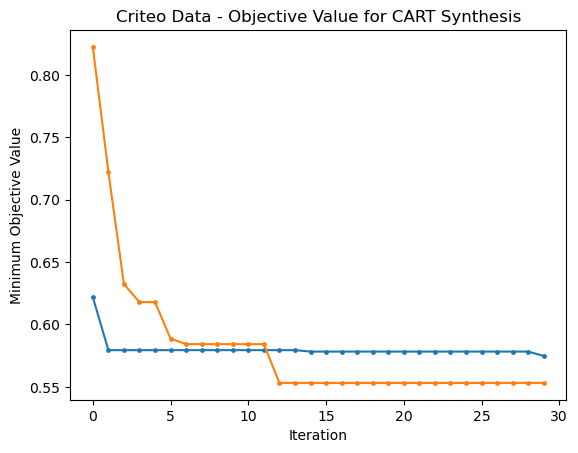

In [17]:
fig = plt.figure()
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Criteo Data - Objective Value for CART Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

In [18]:
optimization_results

[{'best_params': {'gmm': {},
   'multinomial': {},
   'tree': {'f8': {'min_samples_leaf': np.float64(2536675.790983765)},
    'f9': {'min_samples_leaf': np.float64(15000.0)},
    'f4': {'min_samples_leaf': np.float64(15000.0)},
    'f3': {'min_samples_leaf': np.float64(763147.4769733431)},
    'f5': {'min_samples_leaf': np.float64(15000.0)},
    'f6': {'min_samples_leaf': np.float64(5373837.919032853)},
    'f11': {'min_samples_leaf': np.float64(6302002.48178547)},
    'f10': {'min_samples_leaf': np.float64(3960835.2423363887)},
    'f0': {'min_samples_leaf': np.float64(5612056.063714466)},
    'f1': {'min_samples_leaf': np.float64(941485.9875786899)},
    'f7': {'min_samples_leaf': np.float64(15000.0)},
    'f2': {'min_samples_leaf': np.float64(1355978.1756412)}}},
  'best_score': np.float64(0.574748890555731),
  'optimizer': <bayes_opt.bayesian_optimization.BayesianOptimization at 0x21c7ba214f0>},
 {'best_params': {'gmm': {},
   'multinomial': {},
   'tree': {'f8': {'min_samples_leaf

In [19]:
best_params = optimization_results[np.argmin([x['best_score'] for x in optimization_results])]['best_params']

In [20]:
best_state = random_states[np.argmin([x['best_score'] for x in optimization_results])]

In [21]:
# warnings.filterwarnings('ignore')

# again, we are silencing harmless overflow warnings from numpy related to the Yeo-johnson transformation

sds, full_sXs = perform_synthesis_with_param_target(
    train_data=train_data,
    number_synthetic_datasets=20,
    synthesis_steps=synthesis_steps,
    target_params=target_params,
    target_variable=target_variable,
    exog_variables=exog_variables,
    param_values=best_params,
    random_state=best_state
)

In [22]:
np.mean(sds)

np.float64(0.5937864363977106)

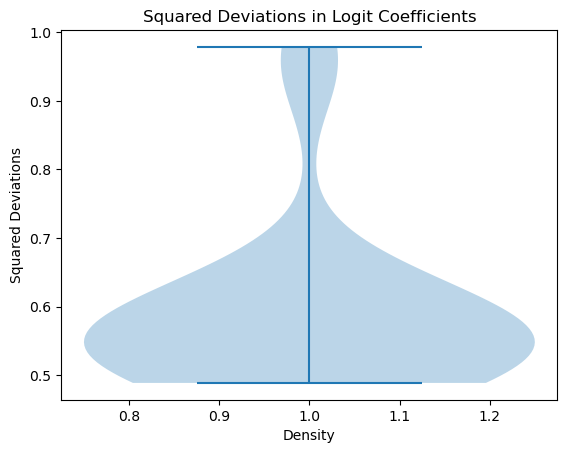

In [23]:
plt.violinplot(sds)
plt.xlabel("Density")
plt.ylabel("Squared Deviations")
plt.title("Squared Deviations in Logit Coefficients")
plt.show()

In [24]:
synthetic_data_path = "../../Data/Criteo/"

for i, sX in enumerate(full_sXs):
    if not os.path.exists(synthetic_data_path):
        os.makedirs(synthetic_data_path)
    sX.to_csv(synthetic_data_path + "cart_" + str(i) + "_" + data_set + ".csv", index=False)

End of file.